# Sparse Monge displacements

This tutorial illustrates the potential of using mixed costs of the form 

$$
c(x, y) = h_\tau(x - y)\text{ with } h_\tau(z) = \frac12\|z\|^2_2 + \tau(z)
$$


where $\tau$ is a sparsity-inducing cost, for instance the $\ell_1$ norm.
When looking at the estimated entropic Monge maps, such cost induces sparsity of the displacements: only a few coordinates of samples from the source distribution change to match the target distribution.
This idea is introduced in {cite}`cuturi:23`.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

## Defining the problem

We illustrate the problem in a 2d setting:

In [3]:
n_source = 30
n_target = 50
n_test = 10
p = 2

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 4)
x = jax.random.normal(keys[0], (n_source, p))

y0 = jax.random.normal(keys[1], (n_target // 2, p)) + jnp.array([5, 0])
y1 = jax.random.normal(keys[2], (n_target // 2, p)) + jnp.array([0, 8])
y = jnp.concatenate([y0, y1])

In [4]:
# Plotting utility
def plot_map(x, y, x_new=None, z=None, ax=None, title=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 8))

    ax.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$")
    ax.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$")
    if z is not None:
        ax.quiver(
            *x_new.T,
            *(z - x_new).T,
            color="k",
            angles="xy",
            scale_units="xy",
            scale=1,
            width=0.007,
        )
        ax.scatter(
            *x_new.T, s=150, edgecolors="k", marker="o", label="$x_{new}$"
        )
        ax.scatter(
            *z.T,
            s=150,
            edgecolors="k",
            marker="X",
            label=r"$T_{x\rightarrow y}(x_{new})$",
        )
    if title is not None:
        ax.set_title(title)
    ax.legend(fontsize=22)

The sources samples $x$ are drawn from a Gaussian distribution, while the targets $y$ are drawn from a mixture of two Gaussians.

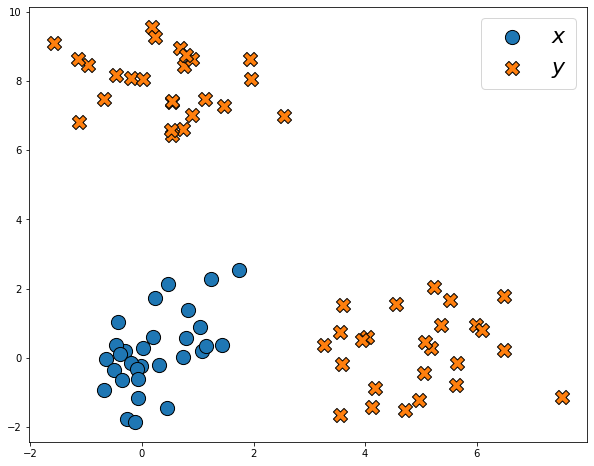

In [5]:
plot_map(x, y)

We also draw some fresh unseen samples from the source distribution:

In [6]:
n_new = 10

x_new = jax.random.normal(keys[3], (n_new, p))

## Standard entropic Monge map

First, let us compute the "standard" entropic map between these two distributions using the $\ell_2^2$ cost, following {cite}`pooladian:21`: we compute the solution of Sinkhorn on the problem, and then use the estimated parameters to compute the dual potentials.

The dual potentials can then be used to build the entropic map with the `transport` function:

In [7]:
solver = jax.jit(sinkhorn.Sinkhorn())


def get_transported_points(cost_fn):
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport(x_new)


transported = get_transported_points(costs.SqEuclidean())

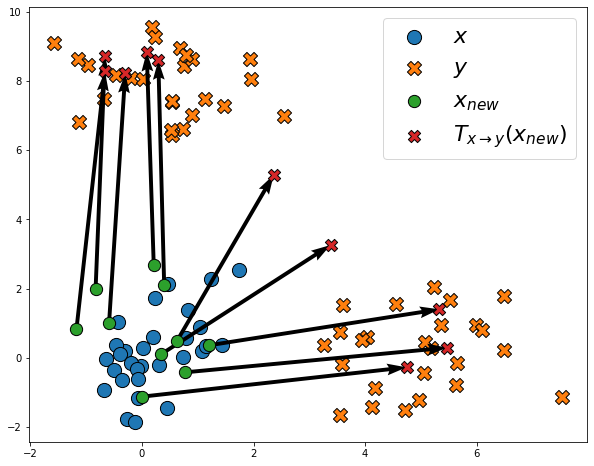

In [8]:
plot_map(x, y, x_new, transported)

We see that the displacements have no particular structure.


## Sparse Monge displacements

We now turn to mixed costs, with the {class}`~ott.geometry.costs.ElasticL1` cost that corresponds to the function

$$
h(z) = \frac12\|z\|_2^2 + \gamma \|z\|_1.
$$

In [9]:
transported = get_transported_points(costs.ElasticL1(gamma=10))

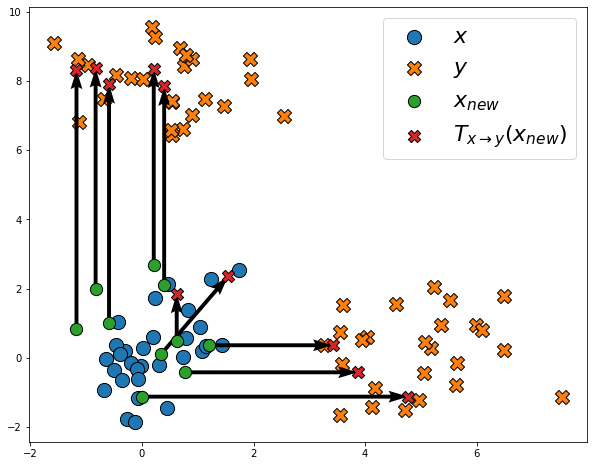

In [10]:
plot_map(x, y, x_new, transported)

We now see that most samples are transported in a sparse way: for most samples, only one coordinate is changed. In this case, that coordinate depends on the sample: some samples move only along the x-axis, while other move only along the y- axis. Some points also move along both axes.

We can investigate the effect of the regularization strenght $\gamma$ on the estimated maps:

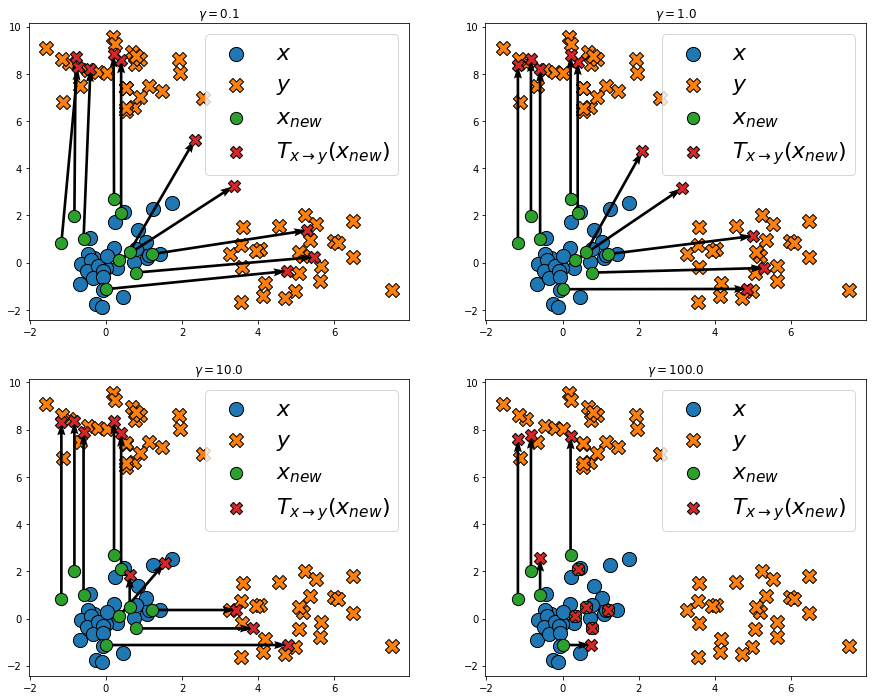

In [11]:
gamma_grid = [0.1, 1.0, 10.0, 100.0]

f, axe = plt.subplots(2, 2, figsize=(15, 12))
for gamma, ax in zip(gamma_grid, axe.ravel()):
    transported = get_transported_points(costs.ElasticL1(gamma=gamma))
    plot_map(x, y, x_new, transported, ax=ax, title=rf"$\gamma = {gamma}$")

We see that a low $\gamma$ leads to no sparsity in the displacements. Increasing $\gamma$, sparsity starts appearing. Taking a really high $\gamma$ also leads to a large shrinkage, as evident in the last plot.

We can also consider other sparsity inducing norms like k-overlap:
$$
h(z) = \frac12\|z\|_2^2+\gamma\|z\|_{k-ov}
$$

In [12]:
transported = get_transported_points(costs.ElasticSqKOverlap(k=1, gamma=1))

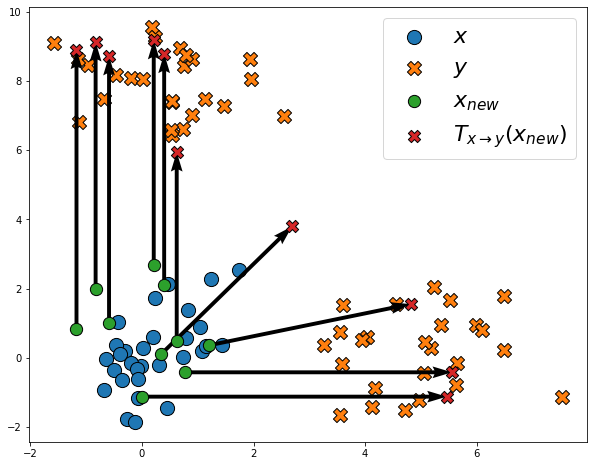

In [13]:
plot_map(x, y, x_new, transported)

This cost induces less shrinkage, but it is more expensive to compute. 